In [ ]:
### This code will produce final figure 1b ... an analysis of the diatom differential gene expression
## To run this code you have created the 'firstimepoints.diff.ex.comparison.csv' and 'endpoint.diff.ex.comparison.csv' tables as a result of the 'differential-expression-analysis.ipynb' notebook
## To run this code you must also have created the "Trinoate.xls" table from the 'trinotate.qsub' script


In [1]:
## :: NOTE :: This script requries the instillation of the following packages. If they are not currently installed, uncomment this code and install them.
#BiocManager::install("ComplexHeatmap")
#BiocManager::install("circlize")
#BiocManager::install("gridBase")
#BiocManager::install("stringr")

In [9]:
##initalize the following packages
library(circlize)
library(ComplexHeatmap)
library(gridBase)
library(stringr)

circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))


Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This mess

In [10]:
##first we we will read in the tables we created in 'differential-expression-analysis.ipynb'
firsttimepoints.table <- read.csv("../output/diatom_transcriptome/firstimepoints.diff.ex.comparison.csv")
endpoint.table <- read.csv("../output/diatom_transcriptome/endpoint.diff.ex.comparison.csv")

##now we will combine that log fold change data into a single data frame
merged.analysis <- data.frame("t_0.5_hours"=firsttimepoints.table$log2FoldChange, "t_24_hours"=endpoint.table$log2FoldChange)
rownames(merged.analysis) <- rownames(firsttimepoints.table)

##and we will remove NAs (DESeq2 will produce NAs when it filters that gene from analysis)
no.nas.merged.analysis <- na.omit(merged.analysis)

In [4]:
##now, the figure sorts the genes into "7" "clusters"
##these are not true clusters, but groupings based on differential expression at 0.5hr (more highly expressed in reseeded, more highly expressed in control, or not signifigant)
##and differential expression at 24hr (more highly expressed in reseeded, more highly expressed in control, or not signifigant)
##eagle eyed reviewers will note that this creates a possible 9 clusters, not seven
##the paper excludes the cluster where a gene is not signfigantly differentially expressed at either timepoint
##the paper also excludes the cluster where a gene is signifigantly more expressed in the reseeded treatment at 24hrs, but underexressed at 0.5
##this is because the paper did not report any "clusters" of that description (in this analysis, i call that cluster zero)

##we will initalize a dummy-dataframe
clustering.no.nas.merged.analysis <- no.nas.merged.analysis
##the "cluster" will be 10, a dummy variable that will help us check for mistakes later
clustering.no.nas.merged.analysis$cluster <- 10

##for each gene we want to know...
for(i in 1:nrow(no.nas.merged.analysis)){
  gene <- rownames(no.nas.merged.analysis)[i]
  fc24 <- endpoint.table[gene,"log2FoldChange"] #what was the log fold change at 24hrs
  fc05 <- firsttimepoints.table[gene,"log2FoldChange"] #what was the logfold change at 0.5hrs
  sig24 <- endpoint.table[gene,"padj"] <= 0.01 & abs(fc24) >= 0.5 #was the change at 24hrs signifigant?
  sig05 <- firsttimepoints.table[gene,"padj"] <= 0.01 & abs(fc05) >= 0.5 #was the change at 0.5hr signifgant?
    ##according to the paper signifigance is "a false discovery rate (FDR) of 0.1 and a minimum log2-fold change of 0.5"

    ##now we will assign each gene a cluster number... the cluster numbers represent...
  if(is.na(sig24)){
    cluster <- 9 #not differentially regulated at both timepoints
  }else if(is.na(sig05)){
    cluster <- 9 #not differentially regulated at both timepoints
  }else if(!(sig24 | sig05)){
    cluster <- 9 #not differentially regulated at both timepoints
  }else if(sig24 & sig05){
    if(fc05 > 0){
      if(fc24 > 0){
        cluster <- 1 ##overexpressed in reseeded at both timepoints
      }else{
        cluster <- 3 ###overexpressed in reseeded at 0.5, underexpressed at 24
      }
    }else{
      if(fc24 < 0){
        cluster <- 2 ##underexpressed at both timepoints
      }else{
        cluster <- 0 ##overexpressed at 24, underexpressed at 0.5 
          ##this is called cluster 0 because it was not in the paper but (spoilers) we will find it in our analysis
      }
    }
  }else{
    if(sig05){
      if(fc05 > 0){
        cluster <- 4 ##overexpressed at 0.5 but not 24
      }else{
        cluster <- 5 ##underexpressed at 0.5 but not 24
      }
    }else{
      if(fc24 > 0){
        cluster <- 6 ##overexpressed at 24 but not 0.5
      }else{
        cluster <- 7 ##underexpressed at 24 but not 0.5
      }
    }
  }
  clustering.no.nas.merged.analysis$cluster[i] <- cluster
}

In [11]:
##now as we approach our graphing we will filter for only genes that are at least differentially expressed in one treatment as the paper did
##cluster 9 is the cluster where neither timepoint has signifigant changes in expression, so lets get rid of that
genes_for_graph <- no.nas.merged.analysis[which(clustering.no.nas.merged.analysis$cluster != 9),]
##and we'll make sure to retain the clustering information
cluster.list <- clustering.no.nas.merged.analysis$cluster[which(rownames(clustering.no.nas.merged.analysis) %in% rownames(genes_for_graph))]

In [12]:
##now the paper says they made the not-signifigant clusters more transparent, so lets kill the vibrancy of those clusters
for(i in 1:nrow(genes_for_graph)){
  if(cluster.list[i] %in% c(4,5)){ ##clusters 4 and 5 are only signifigantly differently expressed at 0.5hrs (see above)
    genes_for_graph$t_24_hours[i] <- genes_for_graph$t_24_hours[i]/8 ##so we will decrease the FLC (which will be our coloring) by a factor of 8 in the 24hr treatments
  }
  if(cluster.list[i] %in% c(6, 7)){ ##clusters 4 and 5 are only signifigantly differently expressed at 24hrs (see above)
    genes_for_graph$t_0.5_hours[i] <- genes_for_graph$t_0.5_hours[i]/8 ##so we will decrease the FLC (which will be our coloring) by a factor of 8 in the 0.5hr treatments
  }
}

##now to make sure the graph is in order, we will save the clusters as an ordered factor
genes_for_graph$cluster <- factor(cluster.list, levels = c("1","2","0","4","5","6","7"))

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.



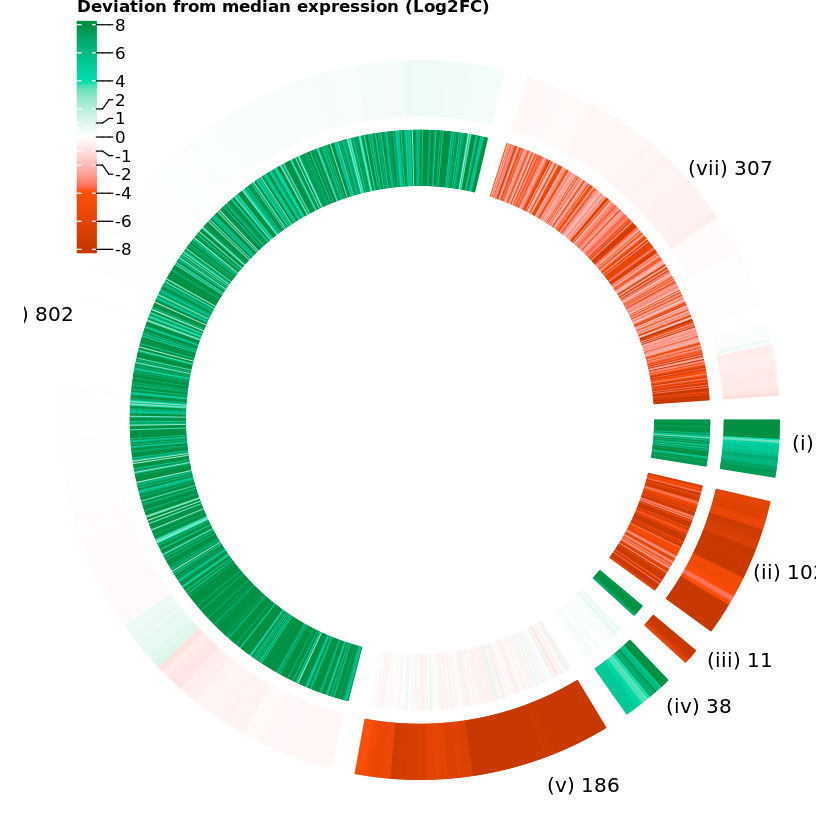

In [13]:
##now let's plot the differential expression
##ignore all warnings! we're trying to print labels "outside the graph space"
##but don't worry, we articifiaclly changed the dimension of the graphing space
##it doesn't know that though, because we're sneaky..........

##first lets make our color pallette for the heatmaps (this was taken using an eyedropper tool from the paper)
col_fun1 = colorRamp2(c(-8, -4, 0, 4, 8), c("#C83900","#FF4F09","#FFFFFF","#00DEAE","#029042"),space="RGB")

##now we intialize a new graphing session for the plotter and circos
circos.clear()
plot.new()

##these next three lines will help us to add the legend at the end
circle_size = unit(1, "snpc") ##this will establish a reference size for the window
pushViewport(viewport(x = 0, y = 0.5, width = circle_size, height = circle_size,
    just = c("left", "center"))) 
par(omi = gridOMI(), new = TRUE) ##these two functions will allow us to have space to plot the legend at the end which is not on top of the circos graph

##now we initialize our circos object, making sure to create whitespace similar to what was found in the paper
circos.par(gap.after = 4, track.margin = c(0.02, 0.02), track.height = 0.15)
#gap.after means between chucks, track.margin means between rings, and track.height is the height of the ring

##now we add the heatmaps for differential expression at each timepoint (circos plots outward-in and clockwise)]
##the 'split' paramater is a map of genes and clusters. the split will carry through every other operation we perform until the circos graph is reinitialized
circos.heatmap(genes_for_graph$t_0.5_hours, split = genes_for_graph$cluster, col = col_fun1)
circos.heatmap(genes_for_graph$t_24_hours, col = col_fun1)

##now we will will place the labels of each cluster on the graph, along with generating the count of genes within that cluster
##the first two numbers are the coordinates (which must be mannually set, as they will change as the number of genes, thickness of bands, etc. changes) and the number of rings outward (here, 3 rings, since we want them all the way out of the graph)
circos.text(340,3,paste("(i)", sum(cluster.list==1)), facing = "downward")
circos.text(425,3,paste("(ii)", sum(cluster.list==2)), facing = "downward")
circos.text(490,3,paste("(iii)", sum(cluster.list==0)), facing = "downward")
circos.text(530,3,paste("(iv)", sum(cluster.list==4)), facing = "downward")
circos.text(620,3,paste("(v)", sum(cluster.list==5)), facing = "downward")
circos.text(1200,3,paste("(vi)", sum(cluster.list==6)), facing = "downward")
circos.text(150,3,paste("(vii)", sum(cluster.list==7)), facing = "downward")

##now we will leave the circos graphing space
circos.clear()

##and enter a space where we can graph the legend

##we'll initialize the legend object
lgd_links = Legend(at = c(-8, -6, -4, -2, -1, 0, 1, 2, 4, 6, 8), col_fun = col_fun1, 
                   title_position = "topleft", title = "Deviation from median expression (Log2FC)")

##and then print it
upViewport()
draw(lgd_links, x = unit(.3, "snpc"), y = circle_size, just = c("top"))

In [ ]:
##already we can see differences between our work and the paper.
##firstly, our graph is much darker. now part of that is not being able to get the color pallette exactly right,
##but also, our analysis seems to have higher logfcs on average (although we cannot know for sure because they did not publish this data)
##that is especially interesting since we found 1,487 differentially expressed genes, but they found 2,088.
##so somehow we found less genes, but they tended to have a higher log-fold-change.
##as I see it, there are many places where our descrepancies could have happened. But they did not publish the parameters they used for HISAT2.
##I got about 70% retention of reads after the mapping step. I wonder if they used slightly laxer parameters. That could also be true with
##DESeq2, for which they also did not share parameters. If they stopped DESeq from filtering out reads with low median expression levels,
##that could explain the more genes with a lower overall LFC. However, I think a "false discovery rate (FDR) of
##0.1 and a minimum log2-fold change of 0.5." is already pretty leniant.
##additionally, a much greater proportion of genes were differentially at 24hrs in my analysis compared to theirs.
##in the paper less than half of genes were differentially expressed at 24hr, not 0.5hrs. In my analysis, that proportion is over two thirds.
##similarily, I see far less genes that were only differentially expressed at 0.5hrs (224 vs 775). 
##I think this takes a lot of the wind out of their conclusions. They said the diatom responded initially to the community,
##and that isn't really being seen here. It seems like, after half an hour, not a lot has changed compared to the 24hr mark,
##which is the opposite of what they see.

In [14]:
##now we'll bring in the functional data from the 'Trinotate.xls' object we generated
##ignore the warnings, its just telling us we have quotations in our cells
trinotations <- read.table('../output/diatom_transcriptome/trinotations/Trinotate.xls', sep = "\t", fill = TRUE, header = TRUE)
colnames(trinotations) <- c("gene_id","transcript_id","sprot_Top_BLASTX_hit","RNAMMER",'prot_id', 'prot_coords',"sprot_Top_BLASTP_hit","Pfam","SignalP","TmHMM","eggnog","Kegg","gene_ontology_BLASTX","gene_ontology_BLASTP","gene_ontology_Pfam","transcript","peptide")

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”


In [15]:
##now lets just look at the genes we're graphing
diff.ex.genes.annotations <- trinotations[which(trinotations$gene_id %in% rownames(genes_for_graph)),]
head(diff.ex.genes.annotations, n = 12)

##now lets take out the 'biological process' info from the GO families in a crude way by searching the columns and saving the info
extract.bio <- function(row){
    if(grepl("biological_process", row['gene_ontology_Pfam'])){
        part <- str_split(row['gene_ontology_Pfam'],fixed("biological_process^"))[[1]][2]
        return(str_split(part,fixed("GO"))[[1]][1])
    }else if(grepl("biological_process", row['gene_ontology_BLASTP'])){
        part <- str_split(row['gene_ontology_BLASTP'],fixed("biological_process^"))[[1]][2]
        return(str_split(part,fixed("GO"))[[1]][1])
    }else if(grepl("biological_process", row['gene_ontology_BLASTX'])){
        part <- str_split(row['gene_ontology_BLASTX'],fixed("biological_process^"))[[1]][2]
        return(str_split(part,fixed("GO"))[[1]][1])
    }else{
        return("")
    }
}
diff.ex.genes.annotations$bio_annotations <- apply(diff.ex.genes.annotations,1,extract.bio)

##now lets go the other direction, and query the gene-names against this list of biological functions we made
find.bio.process <- function(row){
    if(row['genes'] %in% diff.ex.genes.annotations$gene_id){
        return(diff.ex.genes.annotations$bio_annotations[which(diff.ex.genes.annotations$gene_id == row['genes'])])
    }else{
        return("")
    }
}
genes_for_graph$genes <- rownames(genes_for_graph)
genes_for_graph$bio_act <- apply(genes_for_graph,1,find.bio.process)
##we've saved the biological functions to the 'genes_for_graph' data under 'bio_act'

,gene_id,transcript_id,sprot_Top_BLASTX_hit,RNAMMER,prot_id,prot_coords,sprot_Top_BLASTP_hit,Pfam,SignalP,TmHMM,eggnog,Kegg,gene_ontology_BLASTX,gene_ontology_BLASTP,gene_ontology_Pfam,transcript,peptide
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,MSTRG.5,MSTRG.5.1,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
2,MSTRG.11,MSTRG.11.1,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
20,MSTRG.17,MSTRG.17.1,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
21,MSTRG.18,MSTRG.18.1,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
37,MSTRG.37,MSTRG.37.1,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
38,MSTRG.41,MSTRG.41.1,.,.,MSTRG.41.1.p1,33-428[+],.,.,.,.,.,.,.,.,.,.,.
41,MSTRG.40,MSTRG.40.1,.,.,MSTRG.40.1.p1,37-381[-],.,.,.,.,.,.,.,.,.,.,.
47,MSTRG.44,MSTRG.44.1,.,.,MSTRG.44.1.p1,277-642[-],.,.,.,.,.,.,.,.,.,.,.
60,MSTRG.56,MSTRG.56.1,.,.,MSTRG.56.1.p1,1-429[+],.,.,.,.,.,.,.,.,.,.,.


In [16]:
##now what we're going to do is crudly sort through these biological functions, and assign them broad categories.
##from manually looking at the data I know these are the most prevelant categories
genes_for_graph$fatty_acid <- grepl("fatty acid",genes_for_graph$bio_act) ##fatty acid metabolism
genes_for_graph$translation <- grepl("translation",genes_for_graph$bio_act) ##translation
genes_for_graph$fungus <- grepl("fungus",genes_for_graph$bio_act) ##fungus defense response
genes_for_graph$photosynthesis <- grepl("photosy",genes_for_graph$bio_act) ##photosynthesis (and photosystems)
genes_for_graph$porphyrin <- grepl("porphyrin",genes_for_graph$bio_act) ##porphyrin synthesis
genes_for_graph$transmembrane_transport <- grepl("transmembrane transport",genes_for_graph$bio_act) ##transmembrane transport

##now we will assign each a number to make it easier to plot
assign.bio.funcnum <- function(row){
    if(row['fatty_acid'] == TRUE){
        return(1)
    }else if(row['translation'] == TRUE){
        return(2)
    }else if(row['fungus'] == TRUE){
        return(3)
    }else if(row['photosynthesis'] == TRUE){
        return(4)
    }else if(row['porphyrin'] == TRUE){
        return(5)
    }else if(row['transmembrane_transport'] == TRUE){
        return(6)
    }else if(row['bio_act'] != ""){
        return(7)
    }else{
        return(0)
    }
}
        
        ##and save this info in the genes_to_graph object
genes_for_graph$funcnum <- apply(genes_for_graph,1,assign.bio.funcnum)

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.



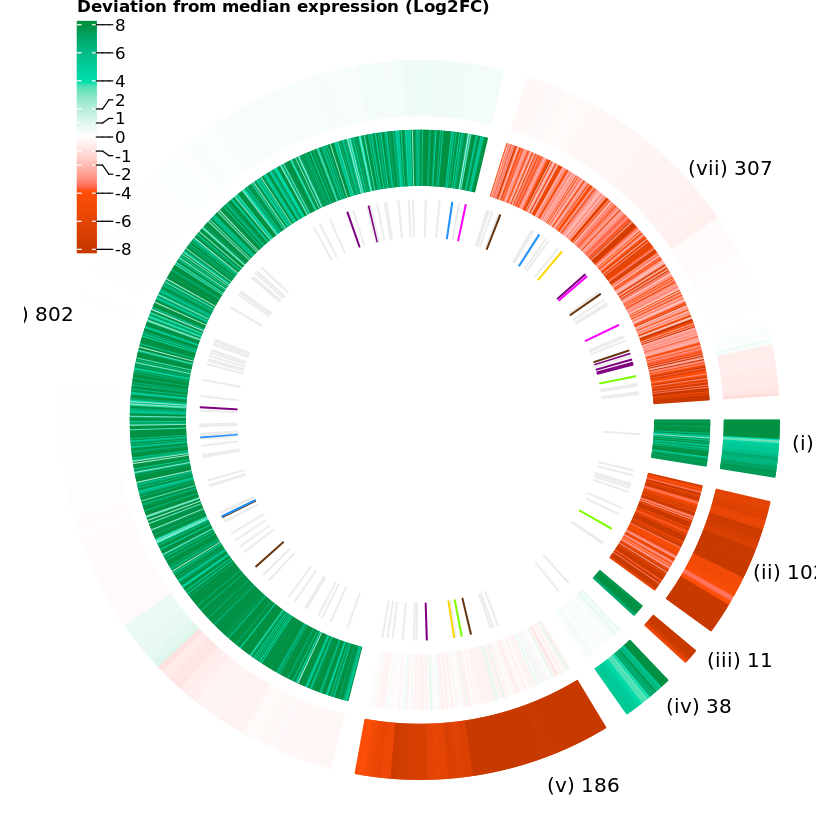

In [17]:
##now lets add the crude functional annotations to our differential expression plot
##the paper has zero information specifying how, if at all, they automated writing gene functions on their plot
##based on the way they do it, and the GO terms they pick, I suspect they did this manually

##we will crete the graph as above.........
col_fun1 = colorRamp2(c(-8, -4, 0, 4, 8), c("#C83900","#FF4F09","#FFFFFF","#00DEAE","#029042"),space="RGB")
circos.clear()
plot.new()
circle_size = unit(1, "snpc")
pushViewport(viewport(x = 0, y = 0.5, width = circle_size, height = circle_size,
    just = c("left", "center")))
par(omi = gridOMI(), new = TRUE)
circos.par(gap.after = 4, track.margin = c(0.02, 0.02), track.height = 0.15)
circos.heatmap(genes_for_graph$t_0.5_hours, split = genes_for_graph$cluster, col = col_fun1)
circos.heatmap(genes_for_graph$t_24_hours, col = col_fun1)
circos.text(340,3,paste("(i)", sum(cluster.list==1)), facing = "downward")
circos.text(425,3,paste("(ii)", sum(cluster.list==2)), facing = "downward")
circos.text(490,3,paste("(iii)", sum(cluster.list==0)), facing = "downward")
circos.text(530,3,paste("(iv)", sum(cluster.list==4)), facing = "downward")
circos.text(620,3,paste("(v)", sum(cluster.list==5)), facing = "downward")
circos.text(1200,3,paste("(vi)", sum(cluster.list==6)), facing = "downward")
circos.text(150,3,paste("(vii)", sum(cluster.list==7)), facing = "downward")

##ah! here's our functional annotation...

##first we will create a colorpallette for each of our funcnum categories
##white = no functional annotation (or at least one we checked for)
##pink - fatty acid metabolism
##purple - translation
##blue - fungus defense reponse
##green - photosynthesis
##yellow - porphyrin biosynthesis
##brown - transmembrane transport
##light-grey - annotated, but not singled out
col_desc_1 = colorRamp2(c(0,1,2,3,4,5,6,7), c("#FFFFFF","#ff00ff","#800080","#1e90ff","#7cfc00","#ffd700","#65350f","#ececec"),space="RGB")
##now lets add this ring to the graph (but make it smaller than the other two)
circos.heatmap(genes_for_graph$funcnum, col = col_desc_1, track.height = 0.1)

##and lets finish the graph as above...
circos.clear()
lgd_links = Legend(at = c(-8, -6, -4, -2, -1, 0, 1, 2, 4, 6, 8), col_fun = col_fun1, 
                   title_position = "topleft", title = "Deviation from median expression (Log2FC)")
upViewport()
draw(lgd_links, x = unit(.3, "snpc"), y = circle_size, just = c("top"))

In [ ]:
##Again, our analysis differs here signifigantly from the paper.
##On the one hand, we also found several fatty acid meabolism genes were differentialy expressed.
##and, we also, for the most part, found that these genes were mainly underexpressed in the reseeded culture after 24hrs,
##compared to the control. However, we did not find any of these genes were differentially expressed in the 0.5hr experiments
##unlike the paper. Also, unlike the paper, we did not find any differentially expressed genes at either timepoint
##that related to the metabolism of urea, tricarboxylic acid, spermidine or leucine, which were two major pathways that could impact the formation of the metabolites investigated in the paper.
##we did however find other metabolite pathways (like porphyrin) we're differentially expressed.
##we also found no evidence for transcriptional changes in nitrate assimilation.
##however, just like the paper, we do find that photosynthesis and photosystem genes were underexpressed at 0.5hrs and 24hrs
##in the reseeded cultures compared to the controls.
##it is also worth noting, 5 fungus defense response genes were found, and were mainly upregulated after 24 hours in the reseeded community. 
##I find this especially interesting to consider to what extent natural fungii are members of the seeding community
##perhaps this is an angle the authors did not notice or did not consider.
##I believe our differences in annotation are mainly due to our approaches to the Trinotate pathway.
##in their methods the authors simply state "Transcript assemblies were annotated on the Trinotate pipeline".
##the trinotate pipeline is highly flexible. there are lots of parameters, but also, there are many optional steps.
##because there was nothing specified I only did the required steps (blastx, blastp, and pfam)
##but I imagine, that they may have more annotations than me because they used some of the optional features and did not mention it.
##further, there were many ways to coerce the GTF transcriptome file from the StringTie process into Trinotate.
##I chose to use gffread to extract the sequences, but they prepared the data for the pipeline in a different way and that
##led to some differences.

In [176]:
##now let's mak it a pdf...

pdf("figure1b.pdf") ##open the pdf graphic environment and name your pdf
##everything from here on will write to the pdf, not the console

##we will crete the graph as above.........
col_fun1 = colorRamp2(c(-8, -4, 0, 4, 8), c("#C83900","#FF4F09","#FFFFFF","#00DEAE","#029042"),space="RGB")
circos.clear()
plot.new()
circle_size = unit(1, "snpc")
pushViewport(viewport(x = 0, y = 0.5, width = circle_size, height = circle_size,
    just = c("left", "center")))
par(omi = gridOMI(), new = TRUE)
circos.par(gap.after = 4, track.margin = c(0.02, 0.02), track.height = 0.15)
circos.heatmap(genes_for_graph$t_0.5_hours, split = genes_for_graph$cluster, col = col_fun1)
circos.heatmap(genes_for_graph$t_24_hours, col = col_fun1)
circos.text(340,3,paste("(i)", sum(cluster.list==1)), facing = "downward")
circos.text(425,3,paste("(ii)", sum(cluster.list==2)), facing = "downward")
circos.text(490,3,paste("(iii)", sum(cluster.list==0)), facing = "downward")
circos.text(530,3,paste("(iv)", sum(cluster.list==4)), facing = "downward")
circos.text(620,3,paste("(v)", sum(cluster.list==5)), facing = "downward")
circos.text(1200,3,paste("(vi)", sum(cluster.list==6)), facing = "downward")
circos.text(150,3,paste("(vii)", sum(cluster.list==7)), facing = "downward")
##white = no functional annotation (or at least one we checked for)
##pink - fatty acid metabolism
##purple - translation
##blue - fungus defense reponse
##green - photosynthesis
##yellow - porphyrin biosynthesis
##brown - transmembrane transport
##light-grey - annotated, but not singled out
col_desc_1 = colorRamp2(c(0,1,2,3,4,5,6,7), c("#FFFFFF","#ff00ff","#800080","#1e90ff","#7cfc00","#ffd700","#65350f","#ececec"),space="RGB")
circos.heatmap(genes_for_graph$funcnum, col = col_desc_1, track.height = 0.1)
circos.clear()
lgd_links = Legend(at = c(-8, -6, -4, -2, -1, 0, 1, 2, 4, 6, 8), col_fun = col_fun1, 
                   title_position = "topleft", title = "Deviation from median expression (Log2FC)")
upViewport()
draw(lgd_links, x = unit(.3, "snpc"), y = circle_size, just = c("top"))

##close the pdf environment, and vwala!
dev.off()

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.

Note: 1 point is out of plotting region in sector '7', track '2'.



png 
  2